In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [69]:
df = pd.read_csv("genes/combined-gene-on-off.csv")
df.head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,celltype,H3K27me3_tss,cluster,gene_type,comment
0,LUZP1,"[213, 55, 11, 40]","[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,HBEC,0.0,cluster0,simple,NaN


In [70]:
overlap_genes = set(df[df["celltype"]=="H9D0"]["gene"]) & set(df[df["celltype"]=="H9D3"]["gene"])
diff_genes = {"DISC1", "SOX2", "HMGB1", "YWHAG"}
len(overlap_genes)

15

In [71]:
# for expressed genes, count within TSS up and down 1M regions, how many up and down regulated.

def get_expression(output):
    rna_df = pd.read_csv(output, 
                     sep='\t', comment='#', header=None,
                     names=['chr', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])

    # 解析attributes列以找到基因名称
    def parse_attributes(attributes_str):
        attributes = {}
        for attribute in attributes_str.split(';'):
            if attribute:
                key, value = attribute.strip().split(' ', 1)
                attributes[key] = value.strip('"')
        return attributes

    rna_df = rna_df[rna_df["type"]=="transcript"]
    rna_df['attributes_parsed'] = rna_df['attributes'].apply(parse_attributes)
    rna_df['gene'] = rna_df['attributes_parsed'].apply(lambda x: x.get('ref_gene_name'))
    rna_df['gene_id'] = rna_df['attributes_parsed'].apply(lambda x: x.get('gene_id', "").split('.')[0])
    rna_df['transcript_id'] = rna_df['attributes_parsed'].apply(lambda x: x.get('transcript_id', "").split('.')[0])
    rna_df['TPM'] = rna_df['attributes_parsed'].apply(lambda x: float(x.get('TPM', 0)))

    # keep highest TPM as the transcript
    rna_df = rna_df[rna_df.TPM > 0]
    rna_df = rna_df.sort_values(by="TPM", ascending=False).drop_duplicates("gene")
    return rna_df

H9D0_expressed_gene = get_expression('~/projects/transcriptome_4D/data/wanlab/RNA_seq/ESC-D0/ESC_D0_bulkRNA.gtf')
H9D3_expressed_gene = get_expression('~/projects/transcriptome_4D/data/wanlab/RNA_seq/ESC-D3/ESC-D3_bulkRNA.gtf')
both_expressed_gene = set(H9D0_expressed_gene["gene"]) & set(H9D3_expressed_gene["gene"])
len(both_expressed_gene)

16863

In [72]:
H9D3_expressed_gene.head(1)

,chr,source,type,start,end,score,strand,phase,attributes,attributes_parsed,gene,gene_id,transcript_id,TPM
1552732,chrM,StringTie,transcript,7586,8269,1000,+,.,"gene_id ""ENSG00000198712.1""; transcript_id ""EN...","{'gene_id': 'ENSG00000198712.1', 'transcript_i...",MT-CO2,ENSG00000198712,ENST00000361739,13986.331055


In [73]:
"PAX6" in both_expressed_gene, "PAX6" in H9D0_expressed_gene["gene"].values,  "PAX6" in H9D3_expressed_gene["gene"].values, 'DISC1'in H9D3_expressed_gene["gene"].values

(False, False, True, True)

In [74]:
H9D3_expressed_gene[H9D3_expressed_gene["gene"]=="DISC1"]

,chr,source,type,start,end,score,strand,phase,attributes,attributes_parsed,gene,gene_id,transcript_id,TPM
821451,chr1,StringTie,transcript,231629390,231702661,1000,+,.,"gene_id ""ENSG00000162946.23""; transcript_id ""E...","{'gene_id': 'ENSG00000162946.23', 'transcript_...",DISC1,ENSG00000162946,ENST00000468399,0.165027


SOX2 chr3 181711925 181714436 181711925


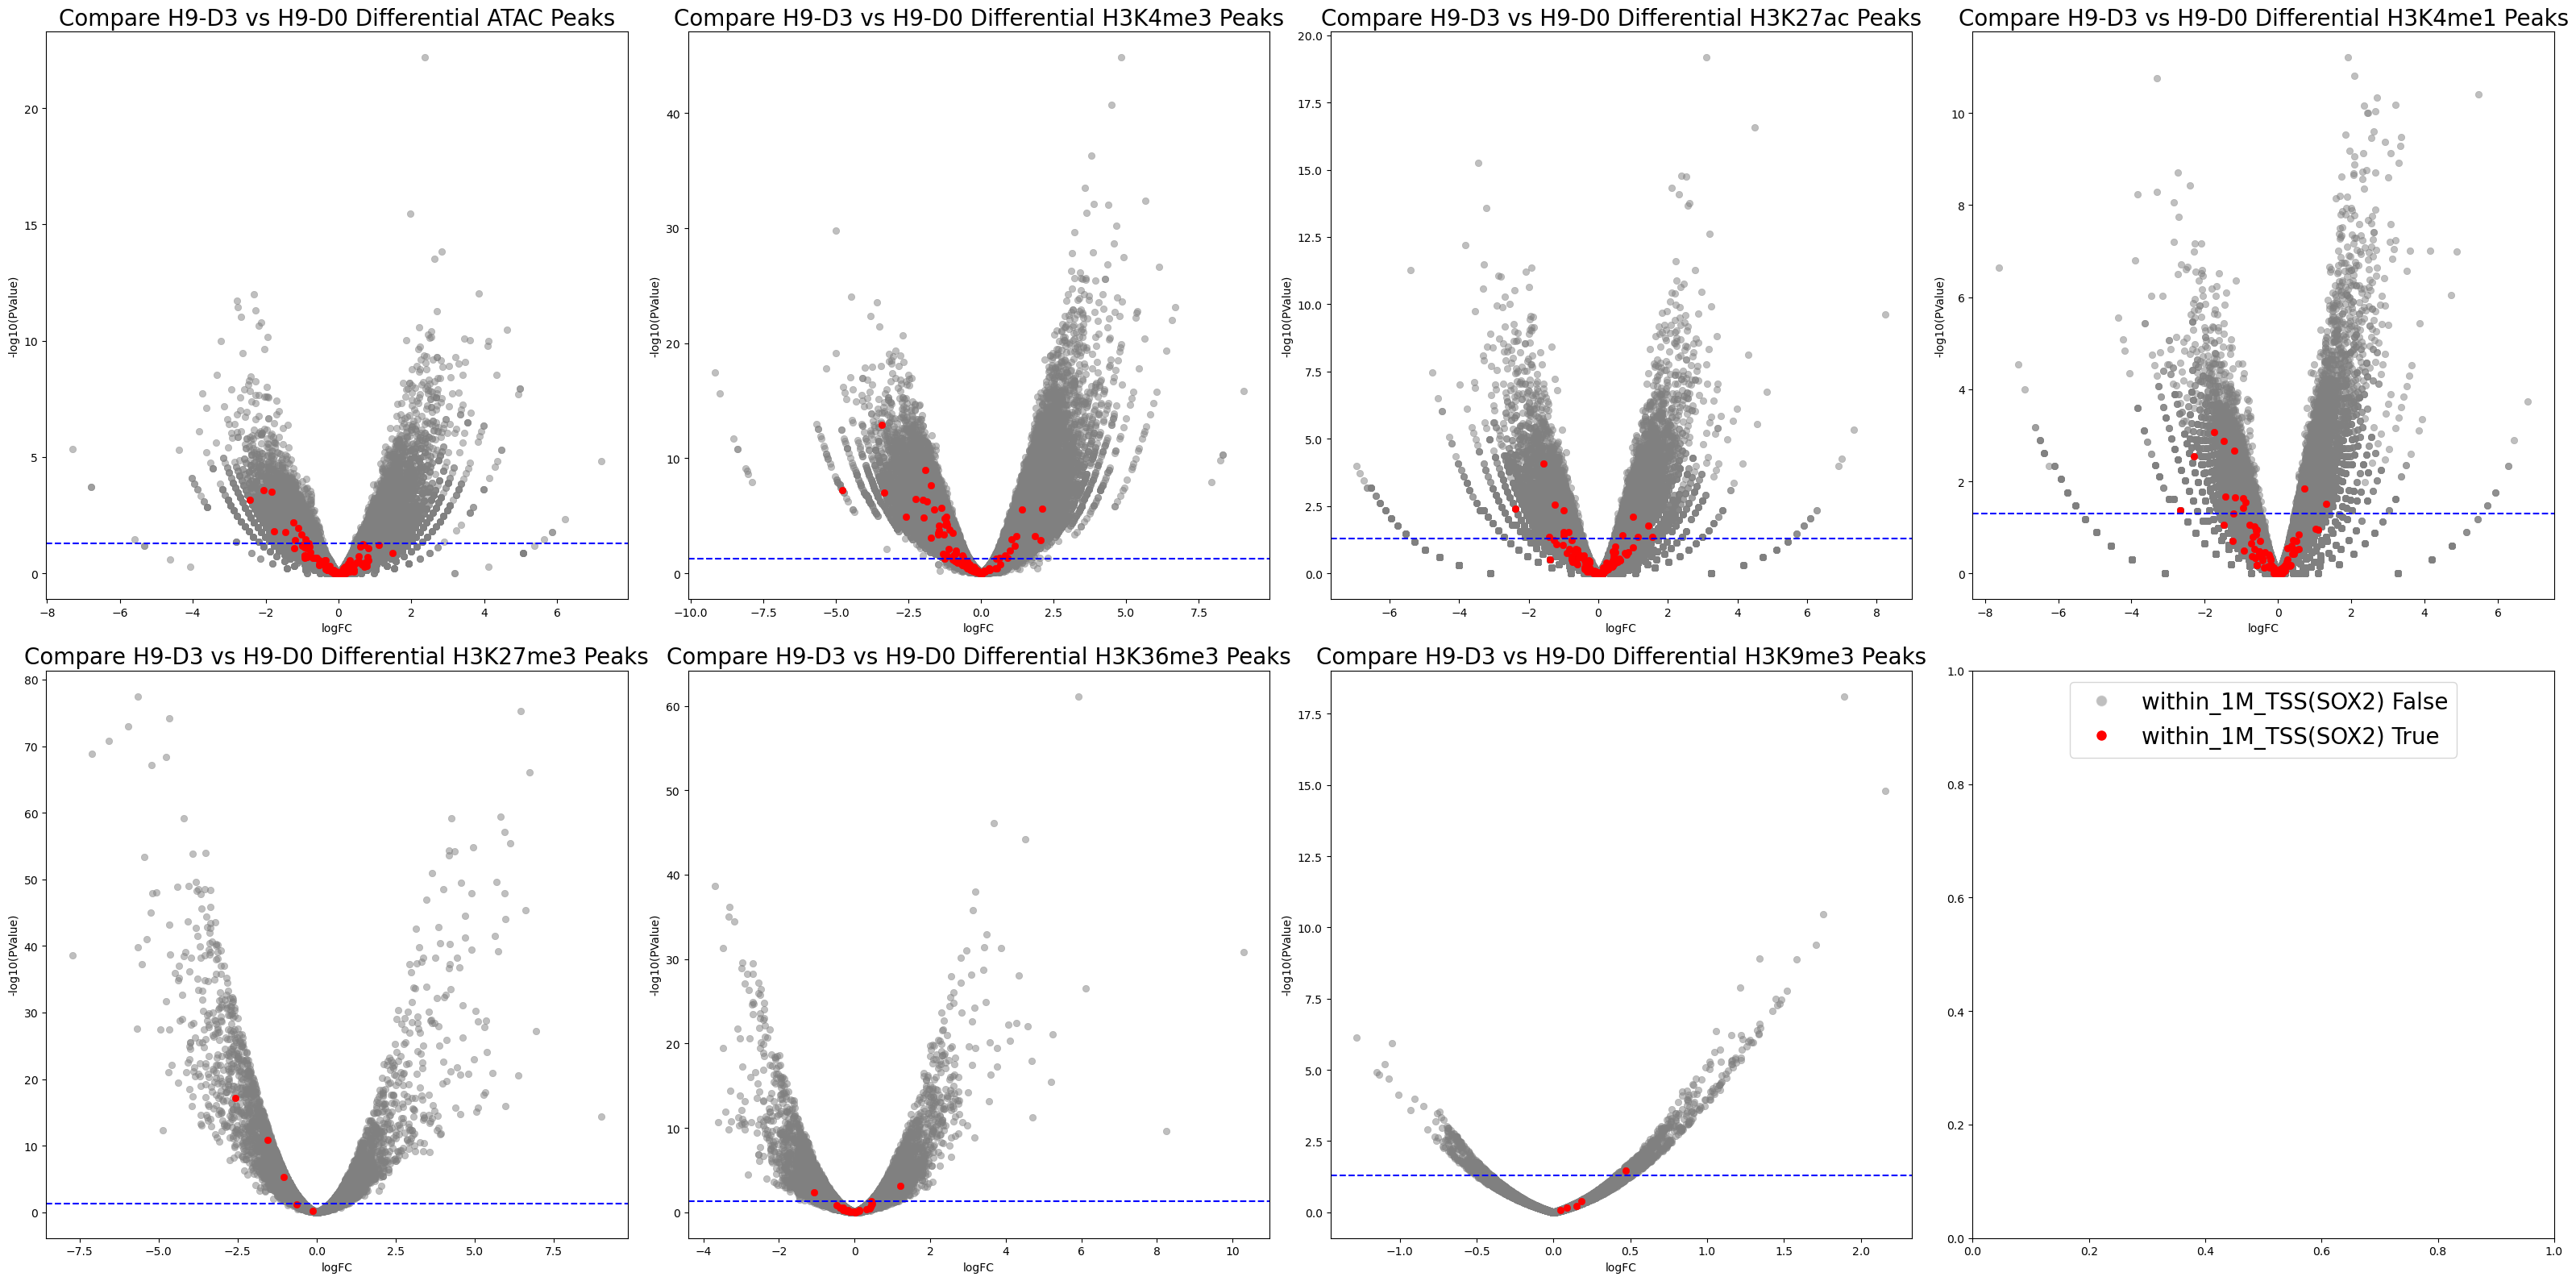

PAX6 chr11 31790727 31811322 31811322


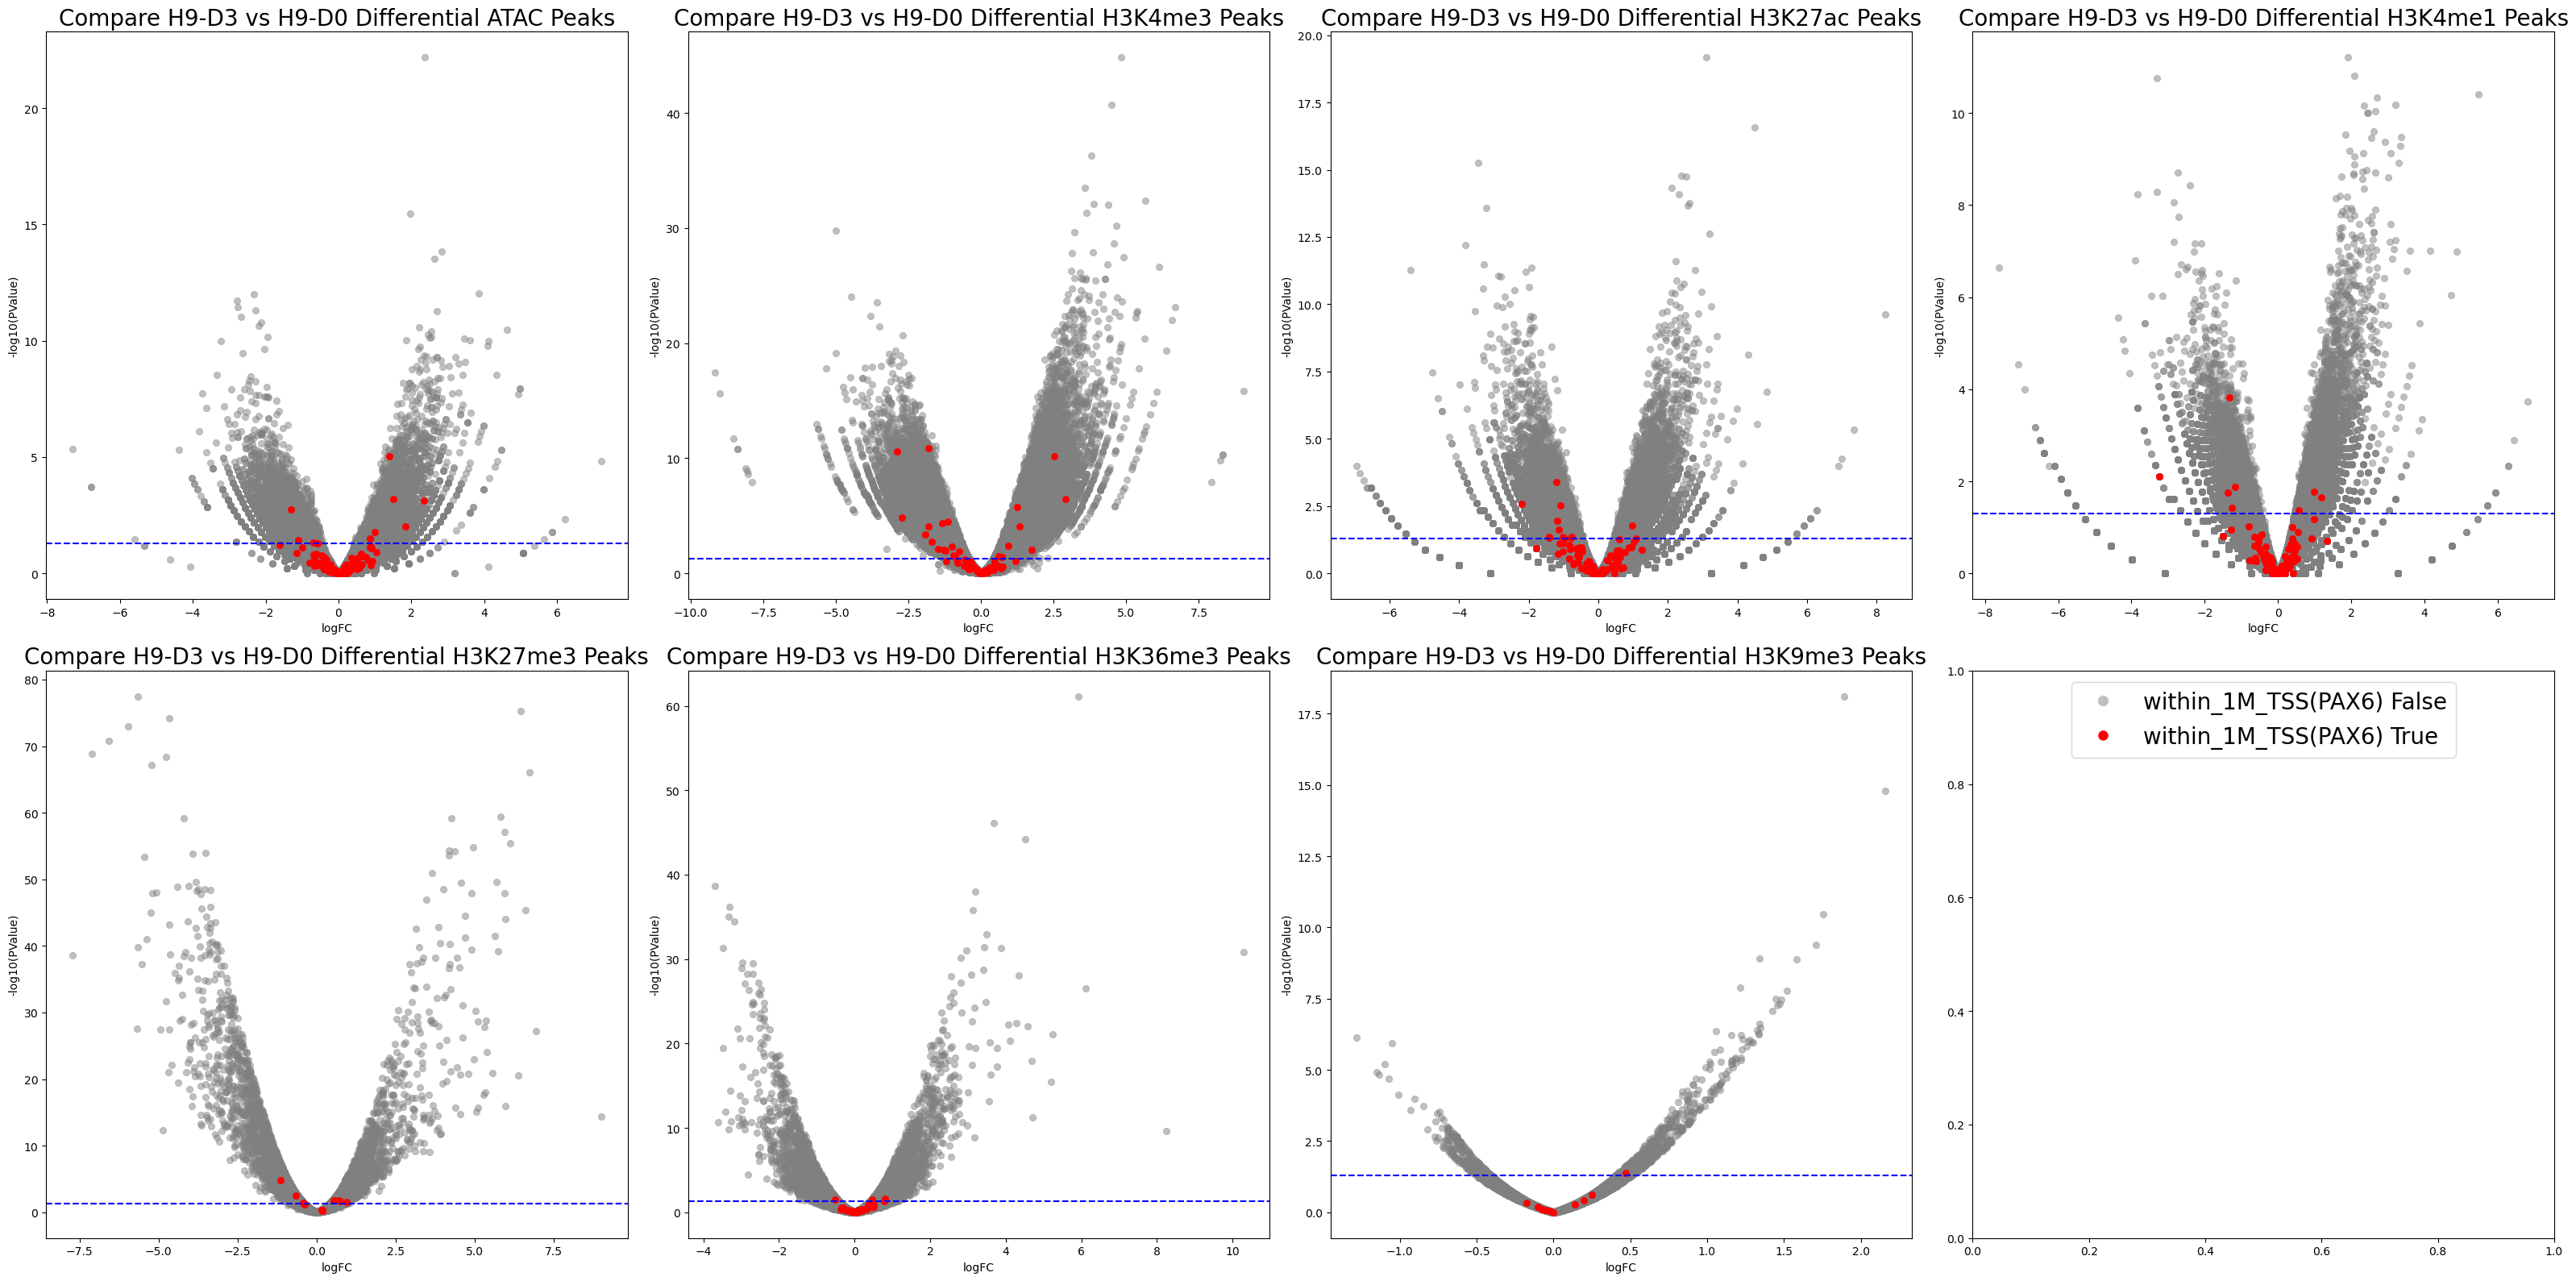

DISC1 chr1 231629390 231702661 231629390


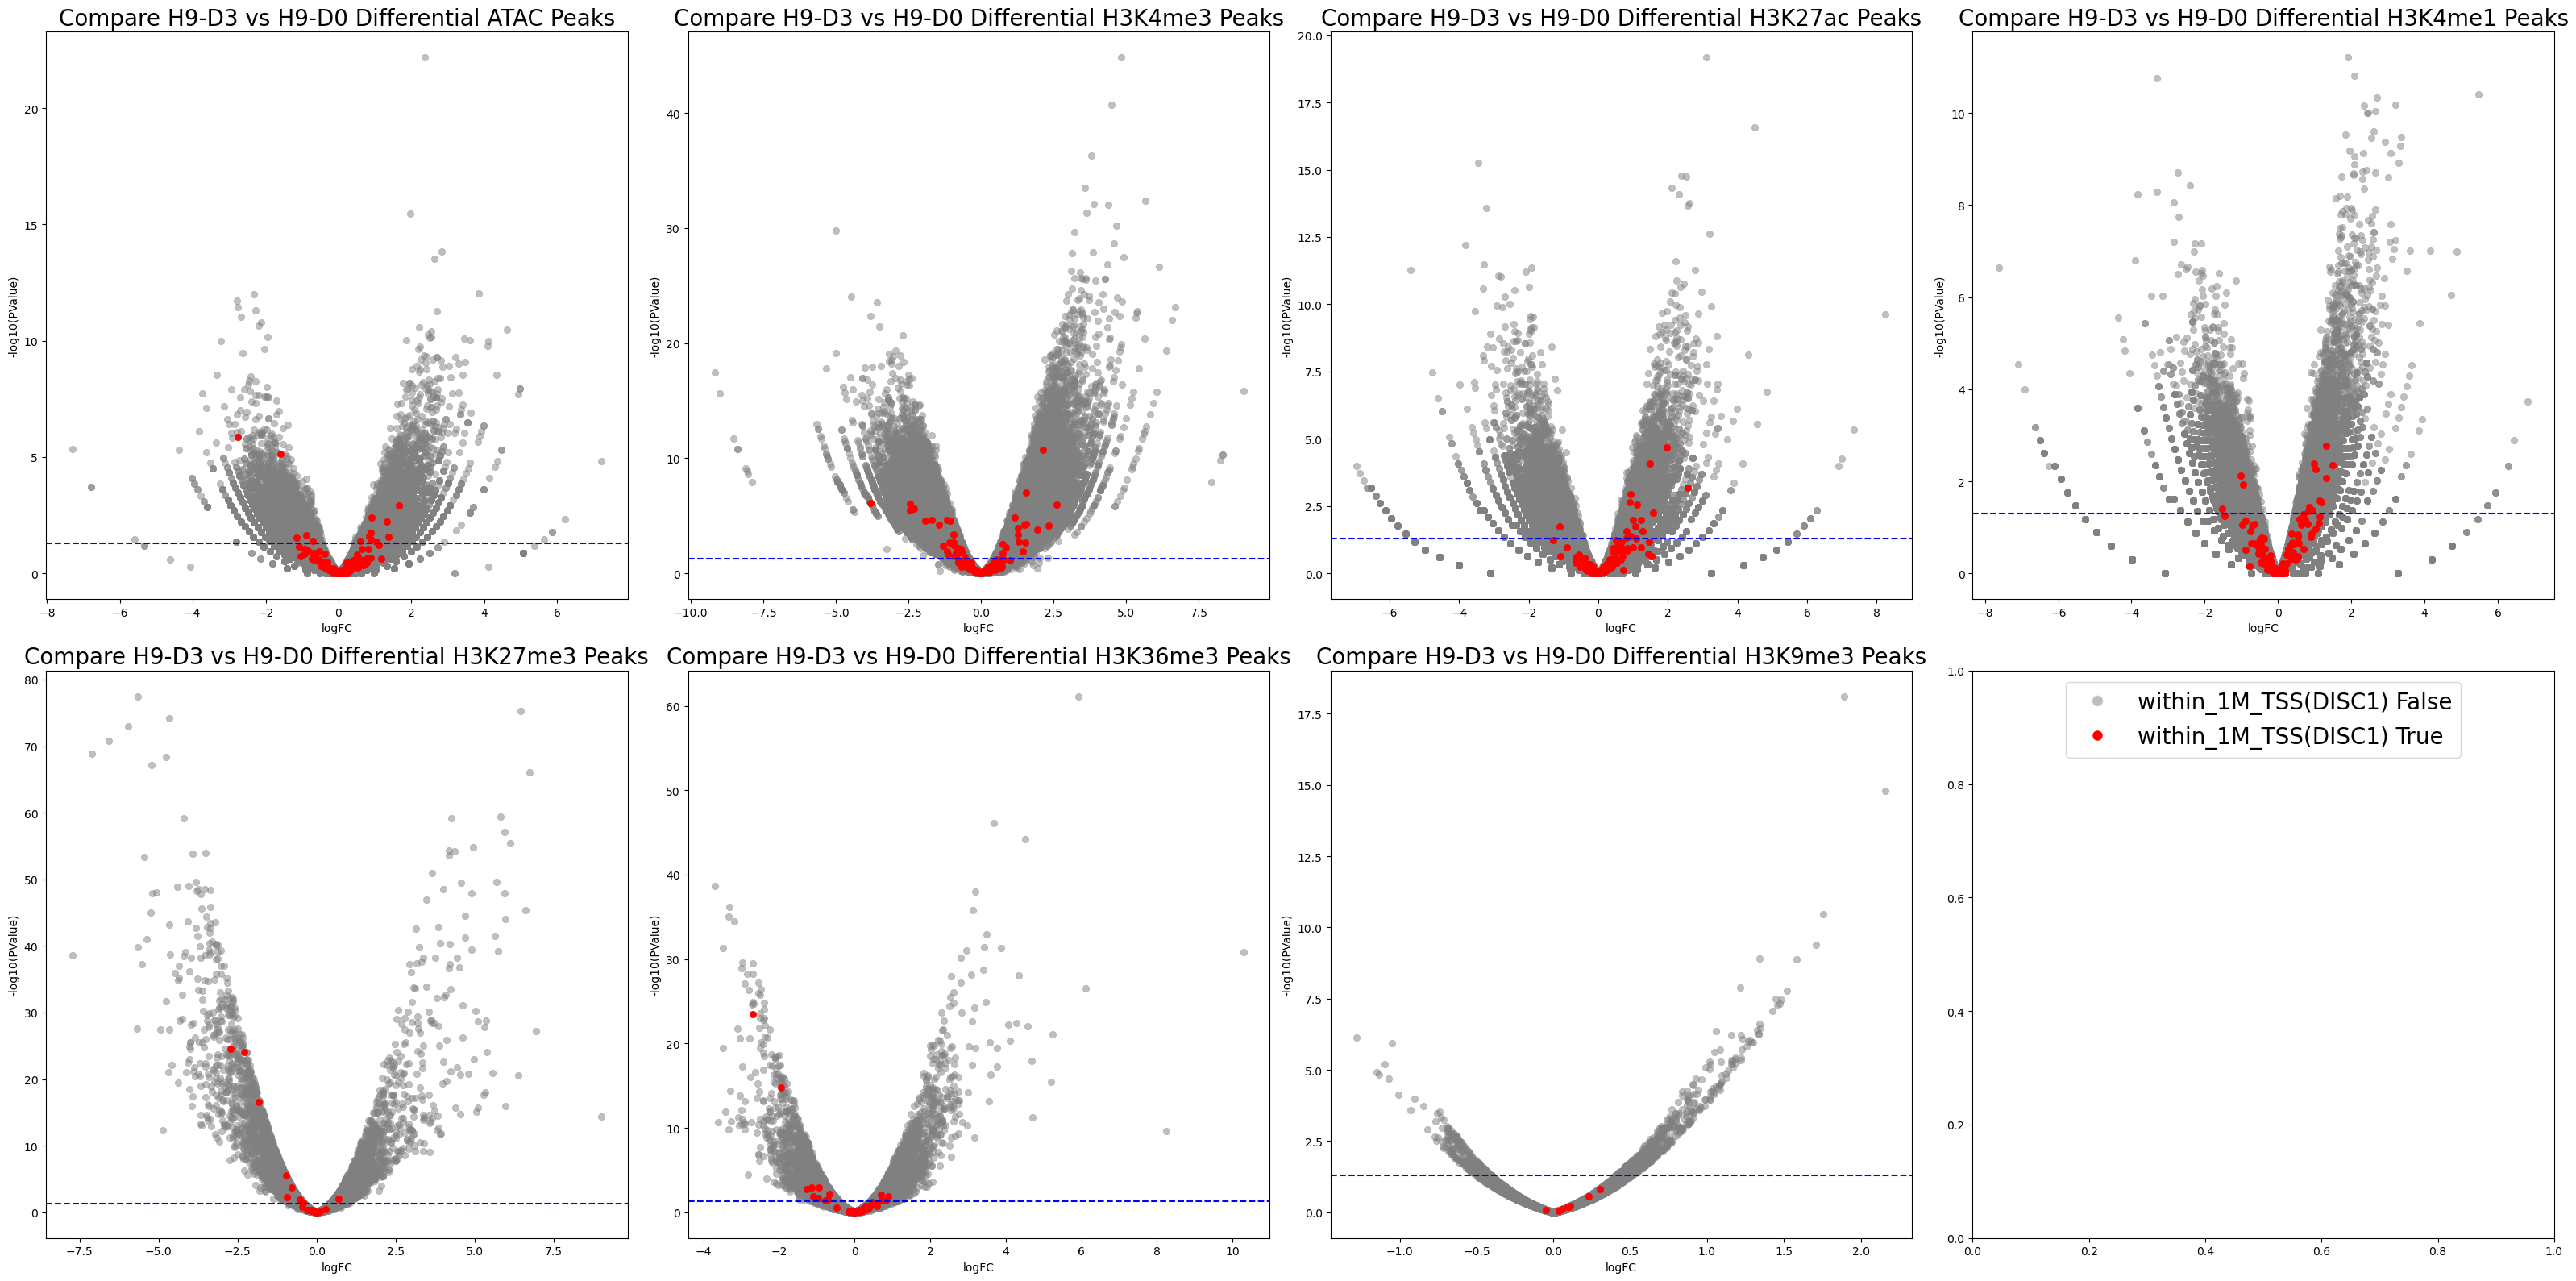

In [76]:
diff_genes = {"DISC1", "SOX2", "PAX6"}
for index, row in H9D3_expressed_gene.iterrows():
    if row["gene"] in diff_genes:
        gene = row["gene"]
        gene_chr, gene_start, gene_end = row["chr"], row["start"], row["end"]
        gene_tss = gene_start if row["strand"] == '+' else gene_end
        
        # Define the region around TSS
        region_start = gene_tss - 1000000
        region_end = gene_tss + 1000000
        
        print(gene, gene_chr, gene_start, gene_end, gene_tss)
        
        
        # Define the histone marks
        histone_marks = ["ATAC", "H3K4me3", "H3K27ac", "H3K4me1", "H3K27me3",  "H3K36me3", "H3K9me3"]


        fig, axes = plt.subplots(2, 4, figsize=(32, 16))
        axes = axes.flatten()
        legend_artist = None

        for i, histone in enumerate(histone_marks):
            # Read the differential regions
            df = pd.read_csv(f"/storage/zhangyanxiaoLab/qihongjian/github/zhanglab-code/projects/transcriptome_4D/code/ESC/diff_enhancers/{histone}_bcv0.1_diff_regions.csv")

            # Check if the regions are near the specified gene
            df[f'within_1M_TSS'] = (df["Chr"] == gene_chr) & (df["Start"] >= region_start) & (df["End"] <= region_end)

            # Create a volcano plot
            scatter_false = sns.scatterplot(data=df[df['within_1M_TSS'] == False], x='logFC', y=-np.log10(df[df['within_1M_TSS'] == False]['PValue']),
                                    color='grey', ax=axes[i], edgecolor=None, alpha=0.5)
            scatter_true = sns.scatterplot(data=df[df['within_1M_TSS'] == True], x='logFC', y=-np.log10(df[df['within_1M_TSS'] == True]['PValue']),
                                           color='red', ax=axes[i], edgecolor=None)
    
            axes[i].set_title(f'Compare H9-D3 vs H9-D0 Differential {histone} Peaks', fontsize=20)
            axes[i].set_xlabel('logFC')
            axes[i].set_ylabel('-log10(PValue)')
            axes[i].axhline(y=-np.log10(0.05), color='blue', linestyle='--')

    
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, alpha=0.5),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)]
        labels = [f'within_1M_TSS({gene}) False', f'within_1M_TSS({gene}) True']
        axes[7].legend(handles, labels, loc='upper center',  fontsize=20, title_fontsize='x-large', ncol=1)




        plt.tight_layout()
        plt.show()